# Magnitude to Photon Count

In this notebook we will use the [PySynPhot](https://pysynphot.readthedocs.io/en/latest/index.html) package to simulate the spectra of the two (brightest) stars in the Alpha Centauri system through the TOLIMAN bandpass. We will then calculate the photon count rate of the two stars.

We will use the PySynPhot built-in Phoenix models for the two stars, which are set of stellar atmosphere models that can be used to generate synthetic spectra. We use the known magnitudes of the two stars (taken from [SIMBAD](http://simbad.cds.unistra.fr/simbad/)) to renormalise the spectra, and then restrict this to the TOLIMAN bandpass of 595nm-695nm. Finally we integrate the resultant spectrum to calculate the photon count rate.

## Setup
First we import the necessary packages and set the parameters of the two stars.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pysynphot as S
import os

%matplotlib inline
plt.rcParams["font.family"] = "monospace"
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

ALPHA_CEN_A_SURFACE_TEMP = 5790.0  # K
ALPHA_CEN_A_METALICITY = 0.2
ALPHA_CEN_A_SURFACE_GRAV = 4.0  # log(g)
ALPHA_CEN_A_MAGNITUDE = 0.01  # vega magnitude

ALPHA_CEN_B_SURFACE_TEMP = 5260.0  # K
ALPHA_CEN_B_METALICITY = 0.23
ALPHA_CEN_B_SURFACE_GRAV = 4.37  # log(g)
ALPHA_CEN_B_MAGNITUDE = 1.33  # vega magnitude

FILTER_MIN_WAVELENGTH = 530.  # nm
FILTER_MAX_WAVELENGTH = 640.  # nm

os.chdir('..'); os.chdir('data')  # changing working directory so pysynphot can find the data

/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd/venv-fmpb/lib/python3.10/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd/venv-fmpb/lib/python3.10/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Next we have to do some housekeeping -- PySynPhot requires us to set the directory of some reference data. We need at a minimum the `mtab/` and `comp/nonhst/` directories which include the master tables and some other stuff, and the Phoenix stellar atlas. Unfortunately they are somewhat sizeable, but it is entirely possible not all of it is required for what we are doing. They are downloadable from the following links:

Master tables and Comp ($\sim$1MB and $\sim$30MB): http://ssb.stsci.edu/trds/tarfiles/synphot1.tar.gz

Download and unzip, and just drag the `mtab/` and `comp/nonhst/` directories into your working directory. You can delete everything else to save space.

Phoenix stellar atlas ($\sim$3GB): http://ssb.stsci.edu/trds/tarfiles/synphot5.tar.gz

Do the same with the `grid/` directory. I've discovered only `grid/phoenix/phoenixm00/`, `grid/phoenix/phoenixm03/`, and `grid/phoenix/catalog.fits` are required for Alpha Centauri, so you can delete the rest to save space. However this is likely not the case for different stars.

We also have to set the area of the telescope -- I have used the TOLIMAN primary area of 12.5cm diameter and 3.2cm diameter hole.

In [2]:
primary = np.pi*(12.5**2 - 3.2**2)

S.setref(graphtable='mtab/57g1733im_tmg.fits',
         comptable='mtab/6cf2109gm_tmc.fits',
         thermtable='mtab/3241637sm_tmt.fits',
         area=primary, # not sure that this actually does anyting tbh
         )

print(f'TOLIMAN Primary Area: {primary:.2f} square cm.')

TOLIMAN Primary Area: 458.70 square cm.


## Generating Spectra
Now we can generate the spectra of the two stars using the [Phoenix](https://pysynphot.readthedocs.io/en/stable/appendixa.html#pysynphot-appendixa-phoenix) models. We feed the models the surface temperature, metallicity and surface gravity of the stars, and then renormalise the spectra to the known magnitudes of the stars in the V band. We then convert the flux to units of photons $s^{-1}cm^{-2}\AA^{-1}$ and the wavelengths to $nm$. Using the `fe_h` query in [SIMBAD](http://simbad.cds.unistra.fr/simbad/) can get you $\text{T}_\text{{eff}}$, $\text{\log{g}}$ and $\text{Fe}_\text{H}$ for different stars.

In [3]:
A_sp = S.Icat(
    "phoenix",
    ALPHA_CEN_A_SURFACE_TEMP,
    ALPHA_CEN_A_METALICITY,
    ALPHA_CEN_A_SURFACE_GRAV,
)

B_sp = S.Icat(
    "phoenix",
    ALPHA_CEN_B_SURFACE_TEMP,
    ALPHA_CEN_B_METALICITY,
    ALPHA_CEN_B_SURFACE_GRAV,
)

# Renormalising to respective magnitudes
VBand = S.ObsBandpass('v')
A_sp = A_sp.renorm(RNval=ALPHA_CEN_A_MAGNITUDE, RNUnits='vegamag', band=VBand)
B_sp = B_sp.renorm(RNval=ALPHA_CEN_B_MAGNITUDE, RNUnits='vegamag', band=VBand)

# Converting units
A_sp.convert('nm')
A_sp.convert('Photlam')
B_sp.convert('nm')
B_sp.convert('Photlam')

sum_sp = A_sp.flux + B_sp.flux

We can now plot the spectra of the two stars and the sum of the two spectra, as a sanity check.

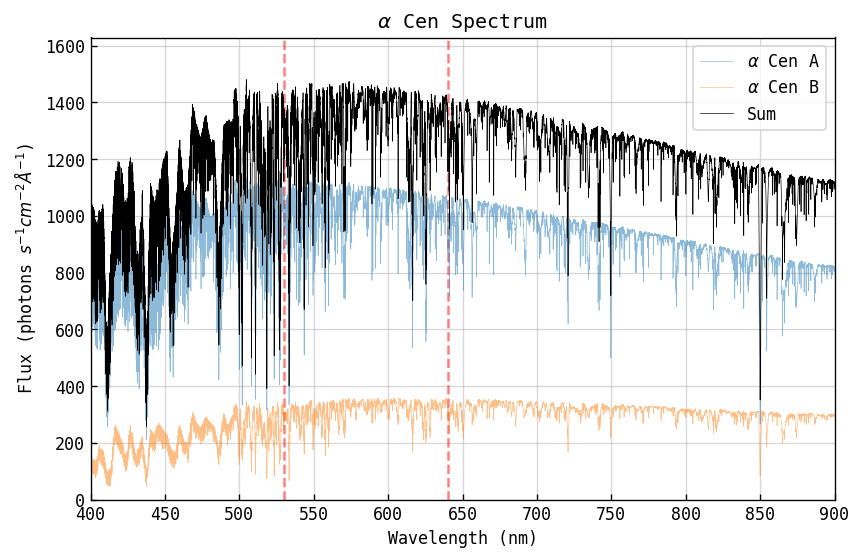

In [4]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot([FILTER_MIN_WAVELENGTH,FILTER_MIN_WAVELENGTH],[0,sum_sp.max()*1.1], 'r--', alpha=.5)
ax.plot([FILTER_MAX_WAVELENGTH,FILTER_MAX_WAVELENGTH],[0,sum_sp.max()*1.1], 'r--', alpha=.5)
ax.plot(A_sp.wave, A_sp.flux, label =r'$\alpha$ Cen A', alpha=.5, lw=.4)
ax.plot(B_sp.wave, B_sp.flux, label =r'$\alpha$ Cen B', alpha=.5, lw=.4)
ax.plot(A_sp.wave, sum_sp, label ='Sum', c ='k', lw=.4)
ax.set(title =r'$\alpha$ Cen Spectrum',
        xlabel = f'Wavelength ({A_sp.waveunits})',
        ylabel = r'Flux (photons $s^{-1}cm^{-2}\AA^{-1}$)',
        xlim = (400, 900),
        xticks = np.linspace(400, 900, 11),
        ylim = (0, sum_sp.max() * 1.1),
        )
ax.grid(alpha = 0.5)
ax.legend()
plt.show()

## Creating Bandpass
Great. Now we can generate the bandpass filter for TOLIMAN. We can use the `Box` function from PySynPhot to generate a flat-top filter with the desired centre wavelength and bandwidth. If you want to add an efficiency factor to change the throughput of the filter, you can include that factor when generating the bandpass.
PySynPhot also has a range of other built-in bandpass filters, which can be found [here](https://pysynphot.readthedocs.io/en/latest/bandpass.html).

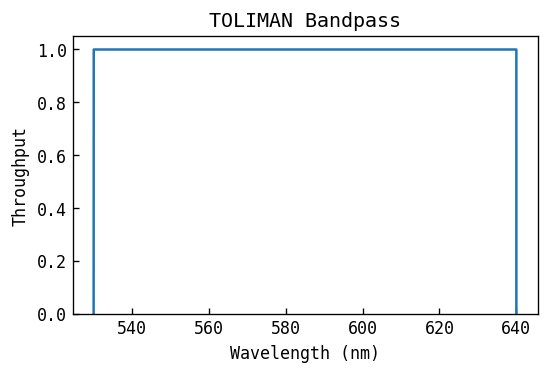

In [5]:
# converting to angstrom for pysynphot
centre = 10 * (FILTER_MIN_WAVELENGTH + FILTER_MAX_WAVELENGTH)/2
bandwidth = 10 * (FILTER_MAX_WAVELENGTH - FILTER_MIN_WAVELENGTH)

bandpass = S.Box(centre, bandwidth) # add efficiency factor here
bandpass.convert('nm')

plt.figure(figsize=(5,3))
plt.plot(bandpass.wave, bandpass.throughput)
plt.ylim(0, 1.05)
plt.xlabel(f'Wavelength ({bandpass.waveunits})')
plt.ylabel('Throughput')
plt.title('TOLIMAN Bandpass')
plt.show()

## Creating an Observation Object
Next we create a PySynPhot `Observation` object for each star, which combines the spectra and the bandpass filter we created.

In [6]:
A_obs = S.Observation(A_sp, bandpass)
B_obs = S.Observation(B_sp, bandpass)
sum_obs = A_obs.flux + B_obs.flux

(<pysynphot.spectrum.Box object at 0x117733a00>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(<pysynphot.spectrum.Box object at 0x117733a00>) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


Plotting as a final sanity check.

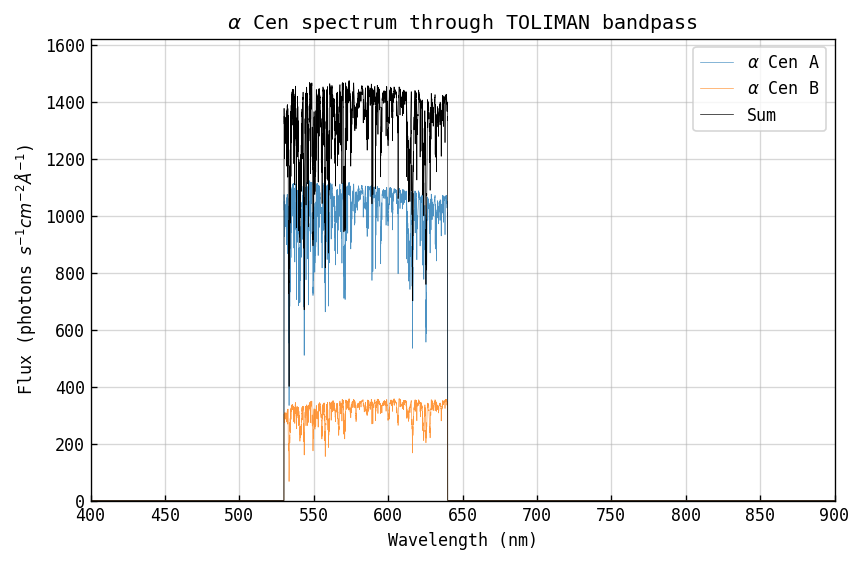

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(A_obs.wave, A_obs.flux, label=r'$\alpha$ Cen A', alpha=.8, lw=.4)
ax.plot(B_obs.wave, B_obs.flux, label=r'$\alpha$ Cen B', alpha=.8, lw=.4)
ax.plot(A_obs.wave, sum_obs, label='Sum', c='k', lw=.4)
ax.set(title = r'$\alpha$ Cen spectrum through TOLIMAN bandpass',
        xlabel = f'Wavelength ({A_sp.waveunits})',
        ylabel = r'Flux (photons $s^{-1}cm^{-2}\AA^{-1}$)',
        xlim = (400, 900),
        xticks = np.linspace(400, 900, 11),
        ylim = (0, sum_obs.max() * 1.1),
        )
ax.grid(alpha = 0.5)
ax.legend()
plt.show()

## Finding the Count Rate
Looks good! Now we can calculate the count rate using the `integrate` method of the `Observation` object. This sums the flux over the wavelength range of the filter, giving a flux value in units of photons per second per square centimetre. We can then multiply this by the primary mirror area to get the total count rate in photons per second. If you have assumed a 100% transmission as I have, this will be the count rate at the pupil plane.

In [8]:
countrate = A_obs.integrate() + B_obs.integrate()
print(f'AlfCen A: {A_obs.integrate():.3e} photons/s/cm/cm; {A_obs.integrate()*primary:.3e} photons/s')
print(f'AlfCen B: {B_obs.integrate():.3e} photons/s/cm/cm; {B_obs.integrate()*primary:.3e} photons/s')
print(f'Total count rate: {countrate:.3e} photons/s/cm/cm; {countrate*primary:.3e} photons/s')

AlfCen A: 1.128e+05 photons/s/cm/cm; 5.176e+07 photons/s
AlfCen B: 3.524e+04 photons/s/cm/cm; 1.616e+07 photons/s
Total count rate: 1.481e+05 photons/s/cm/cm; 6.793e+07 photons/s
